In [0]:
!pip install arcgis
!pip install geopandas
!pip install descartes

In [1]:
from arcgis.gis import GIS
from arcgis.geocoding import geocode, reverse_geocode
from arcgis.geometry import Point

import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona

In [2]:
gis = GIS()

In [3]:
df = pd.read_csv("direcciones.csv", sep=";", encoding="cp1252")
df.head()

,Campo1,CLIENTE,SERVICIO,TIPOVIA,NOMBREVIA,PUERTA,PISO,MZ,LOTE,DISTRITO,...,TAP,BORNE,Campo31,Campo32,Campo33,Campo34,Campo35,ID,PAIS,DEPARTAMENTO
0,PUN,6661946,5714017,ND,.,0,NaN,C,10,JULIACA,...,9.0,1.0,8/03/2017,09:32:58,7507925.0,S,G003,1,PERÚ,PUNO
1,PUN,6708518,5714051,JR,PORRAS BARRENECHEA RAUL,219,NaN,NaN,NaN,JULIACA,...,3.0,1.0,21/03/2017,18:31:39,7507926.0,S,G003,2,PERÚ,PUNO
2,PUN,6711806,5799021,NaN,TUPAC YUPANQUI,0,NaN,H12,8,JULIACA,...,10.0,1.0,22/03/2017,18:25:57,7608640.0,S,G003,3,PERÚ,PUNO
3,PUN,6740184,5821315,JR,VILQUE CHICO,415,NaN,NaN,NaN,JULIACA,...,14.0,1.0,30/03/2017,15:51:03,7635893.0,S,G003,4,PERÚ,PUNO
4,PUN,6740202,5821277,JR,24 DE JUNIO,124,NaN,NaN,NaN,JULIACA,...,7.0,1.0,30/03/2017,15:56:03,7634846.0,S,G003,5,PERÚ,PUNO


In [4]:
# df["ADDRESS"] = df["DIRECCION"].apply(lambda x: x + ", Puno, PER")
df["ADDRESS"] = df["DIRECCION"].apply(lambda x: x.replace("PERÚ", "PER"))
# df["ADDRESS"] = df["DIRECCION"]
df["x"] = 0
df["y"] = 0
df["Match_addr"] = ""
df["Score"] = ""

In [5]:
df.head()

,Campo1,CLIENTE,SERVICIO,TIPOVIA,NOMBREVIA,PUERTA,PISO,MZ,LOTE,DISTRITO,...,Campo34,Campo35,ID,PAIS,DEPARTAMENTO,ADDRESS,x,y,Match_addr,Score
0,PUN,6661946,5714017,ND,.,0,NaN,C,10,JULIACA,...,S,G003,1,PERÚ,PUNO,"MZ C LOTE 10, UR RINCONADA, JULIACA, PER",0,0,,
1,PUN,6708518,5714051,JR,PORRAS BARRENECHEA RAUL,219,NaN,NaN,NaN,JULIACA,...,S,G003,2,PERÚ,PUNO,"JR PORRAS BARRENECHEA RAUL 219, JULIACA, PER",0,0,,
2,PUN,6711806,5799021,NaN,TUPAC YUPANQUI,0,NaN,H12,8,JULIACA,...,S,G003,3,PERÚ,PUNO,"MZ H12 LOTE 8, MUN. LA CAPILLA, JULIACA, PER",0,0,,
3,PUN,6740184,5821315,JR,VILQUE CHICO,415,NaN,NaN,NaN,JULIACA,...,S,G003,4,PERÚ,PUNO,"JR VILQUE CHICO 415, JULIACA, PER",0,0,,
4,PUN,6740202,5821277,JR,24 DE JUNIO,124,NaN,NaN,NaN,JULIACA,...,S,G003,5,PERÚ,PUNO,"JR 24 DE JUNIO 124, JULIACA, PER",0,0,,


In [6]:
def extractAddress(df, indice, idDf, address):
    gis = GIS()
    geocode_result = geocode(address = df.iloc[indice][address], as_featureset=True, max_locations=1, search_extent=juliaca["extent"]) # Cambiar la dirección
#     geocode_result = geocode(address = df.iloc[indice][address], as_featureset=True, max_locations=3, location=(-69.904451,-15.074528), distance=1500) # Cambiar la dirección
    for x in geocode_result.features:
        gdpoint = x.as_dict["geometry"]
        attr = x.as_dict["attributes"]
        df = df.append(pd.Series([df.iloc[indice][idDf], gdpoint["x"], gdpoint["y"], attr["Match_addr"], attr["Score"]], index=["CLIENTE", "x", "y", "Match_addr", "Score"] ), ignore_index=True)
    return df


In [7]:
# for n in range(len(df)):
for n in range(300):
    if n%10==0: print(n)
    df = extractAddress(df, n, "CLIENTE", "ADDRESS")

0


NameError: name 'juliaca' is not defined

In [0]:
juliaca = geocode("Juliaca, PER")[0]
juliaca["extent"]

{'xmax': -69.98443999999996,
 'xmin': -70.27643999999997,
 'ymax': -15.339349999999925,
 'ymin': -15.631349999999927}

In [0]:
data = df[df["x"] != 0]
list_cli = list(set(data["CLIENTE"]))
data = df[df["CLIENTE"].isin(list_cli)]
data.head()

,Campo1,CLIENTE,SERVICIO,TIPOVIA,NOMBREVIA,PUERTA,PISO,MZ,LOTE,DISTRITO,TIPOURB,NOMBREURB,DIRECCION,ESTADO,Campo21,Campo22,Campo23,Campo24,NODO,Campo26,PLANO,AMPLIF,TAP,BORNE,Campo31,Campo32,Campo33,Campo34,Campo35,ID,PAIS,DEPARTAMENTO,ADDRESS,x,y,Match_addr,Score,geometry
0,PUN,6661946,5714017.0,ND,.,0,NaN,C,10,JULIACA,0,UR RINCONADA,"MZ C LOTE 10, UR RINCONADA, JULIACA, PERÚ",3.0,2.0,33.0,20.0,9.0,JK,106,G013,3.0,9.0,1.0,8/03/2017,09:32:58,7507925.0,S,G003,1.0,PERÚ,PUNO,"MZ C LOTE 10, UR RINCONADA, JULIACA, PER",0.0,0.0,,,POINT (0 0)
1,PUN,6708518,5714051.0,JR,PORRAS BARRENECHEA RAUL,219,NaN,NaN,NaN,JULIACA,NaN,SN,"JR PORRAS BARRENECHEA RAUL 219, JULIACA, PERÚ",3.0,2.0,33.0,20.0,9.0,JK,107,G019,1.0,3.0,1.0,21/03/2017,18:31:39,7507926.0,S,G003,2.0,PERÚ,PUNO,"JR PORRAS BARRENECHEA RAUL 219, JULIACA, PER",0.0,0.0,,,POINT (0 0)
2,PUN,6711806,5799021.0,NaN,TUPAC YUPANQUI,0,NaN,H12,8,JULIACA,0,MUN. LA CAPILLA,"MZ H12 LOTE 8, MUN. LA CAPILLA, JULIACA, PERÚ",3.0,2.0,33.0,20.0,9.0,JK,102,G003,3.0,10.0,1.0,22/03/2017,18:25:57,7608640.0,S,G003,3.0,PERÚ,PUNO,"MZ H12 LOTE 8, MUN. LA CAPILLA, JULIACA, PER",0.0,0.0,,,POINT (0 0)
3,PUN,6740184,5821315.0,JR,VILQUE CHICO,415,NaN,NaN,NaN,JULIACA,0,UR SANTA ROSA II,"JR VILQUE CHICO 415, JULIACA, PERÚ",5.0,2.0,26.0,20.0,9.0,JK,102,G002,4.0,14.0,1.0,30/03/2017,15:51:03,7635893.0,S,G003,4.0,PERÚ,PUNO,"JR VILQUE CHICO 415, JULIACA, PER",0.0,0.0,,,POINT (0 0)
4,PUN,6740202,5821277.0,JR,24 DE JUNIO,124,NaN,NaN,NaN,JULIACA,0,UR JORGE CHAVEZ,"JR 24 DE JUNIO 124, JULIACA, PERÚ",3.0,2.0,26.0,20.0,9.0,JK,105,G010,2.0,7.0,1.0,30/03/2017,15:56:03,7634846.0,S,G003,5.0,PERÚ,PUNO,"JR 24 DE JUNIO 124, JULIACA, PER",0.0,0.0,,,POINT (0 0)


In [0]:
data = data[data["x"]!=0]

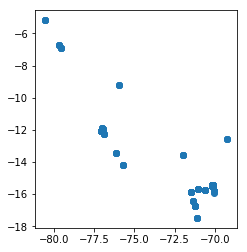

In [0]:
geometry = [Point(xy) for xy in zip(data.x, data.y)]
crs = {'init': 'epsg:4326'} #https://www.spatialreference.org/ref/epsg/4326/ %matplotlib inline
geo_df = GeoDataFrame(data, crs=crs, geometry=geometry)
geo_df.plot()

In [0]:
import folium

gjson = geo_df.to_crs(epsg='4326').to_json()

mapa = folium.Map([-15.5, -70], zoom_start=10, tiles='openstreetmap')
points = folium.features.GeoJson(gjson)
mapa.add_children(points)
mapa

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  import sys


In [0]:
geo_df.to_file(driver='ESRI Shapefile', filename='data.shp')


In [8]:
from arcgis.gis import GIS
from arcgis.geocoding import geocode, reverse_geocode
from arcgis.geometry import Point

import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import fiona

gis = GIS()

class findAdress(object):
    def __init__(self, *args):
        self.pathFilename = args[0]
        self.fieldIndice = args[1] # CLIENTE
        self.fieldAddress = args[2] # DIRECCION
        self.ubicacion = args[3] # Peru
        self.output = args[4]

    def assignFieldsDF(self):
        self.df = pd.read_csv(self.pathFilename, sep=";", encoding="cp1252")
        self.df["ADDRESS"] = self.df[self.fieldAddress]
        self.df["x"], self.df["y"] = 0, 0
        self.df["Match_addr"] = ""
        self.df["Score"] = ""

    def extractAddress(self, indice):
        print(self.ubicacion)
        zona_extent = geocode(self.ubicacion)[0]
        geocode_result = geocode(address = self.df.iloc[indice][self.fieldAddress],
                                as_featureset=True,
                                max_locations=1,
                                search_extent=zona_extent["extent"])
        for x in geocode_result.features:
            gdpoint = x.as_dict["geometry"]
            attr = x.as_dict["attributes"]
            print(type(self.df))
            print(indice)
            print(self.fieldIndice)
            print(self.df.iloc[indice][self.fieldIndice])
            self.df = self.df.append(
                pd.Series([self.df.iloc[indice][self.fieldIndice],
                    gdpoint["x"],
                    gdpoint["y"],
                    attr["Match_addr"],
                    attr["Score"]],
                    index=[self.fieldIndice, "x", "y", "Match_addr", "Score"] ), ignore_index=True)

    def main(self):
        self.assignFieldsDF()
        for n in range(300):
            if n%10 == 0: print(n)
            self.df = self.extractAddress(n)

        data = self.df[self.df["x"] != 0]
        list_cli = list(set(data[self.fieldIndice]))
        data = self.df[self.df[self.fieldIndice].isin(list_cli)]

        data = data[data["x"]!=0]

        geometry = [Point(xy) for xy in zip(data.x, data.y)]
        crs = {'init': 'epsg:4326'}
        geo_df = GeoDataFrame(data, crs=crs, geometry=geometry)

        geo_df.to_file(driver='ESRI Shapefile', filename=self.output)


In [9]:
if __name__ == '__main__':
    # try:
    pathFilename = r'direcciones.csv'
    fieldIndice = 'CLIENTE'
    fieldAddress = 'DIRECCION'
    ubicacion = 'Juliaca, PER'
    output = r'data.shp'

    poo = findAdress(pathFilename, fieldIndice, fieldAddress, ubicacion, output)
    poo.main()

0
Juliaca, PER
<class 'pandas.core.frame.DataFrame'>
0
CLIENTE
Juliaca, PER


AttributeError: 'NoneType' object has no attribute 'iloc'

In [11]:
pathFilename = 'direcciones.csv'
fieldIndice = 'CLIENTE'
fieldAddress = 'DIRECCION'
ubicacion = 'Juliaca, PER'
indice = 0

df = pd.read_csv(pathFilename, sep=";", encoding="cp1252")
df["ADDRESS"] = df[fieldAddress]
df["x"], df["y"] = 0, 0
df["Match_addr"] = ""
df["Score"] = ""
df.iloc[indice][fieldIndice]

6661946

In [12]:
df

,Campo1,CLIENTE,SERVICIO,TIPOVIA,NOMBREVIA,PUERTA,PISO,MZ,LOTE,DISTRITO,...,Campo34,Campo35,ID,PAIS,DEPARTAMENTO,ADDRESS,x,y,Match_addr,Score
0,PUN,6661946,5714017,ND,.,0,NaN,C,10,JULIACA,...,S,G003,1,PERÚ,PUNO,"MZ C LOTE 10, UR RINCONADA, JULIACA, PERÚ",0,0,,
1,PUN,6708518,5714051,JR,PORRAS BARRENECHEA RAUL,219,NaN,NaN,NaN,JULIACA,...,S,G003,2,PERÚ,PUNO,"JR PORRAS BARRENECHEA RAUL 219, JULIACA, PERÚ",0,0,,
2,PUN,6711806,5799021,NaN,TUPAC YUPANQUI,0,NaN,H12,8,JULIACA,...,S,G003,3,PERÚ,PUNO,"MZ H12 LOTE 8, MUN. LA CAPILLA, JULIACA, PERÚ",0,0,,
3,PUN,6740184,5821315,JR,VILQUE CHICO,415,NaN,NaN,NaN,JULIACA,...,S,G003,4,PERÚ,PUNO,"JR VILQUE CHICO 415, JULIACA, PERÚ",0,0,,
4,PUN,6740202,5821277,JR,24 DE JUNIO,124,NaN,NaN,NaN,JULIACA,...,S,G003,5,PERÚ,PUNO,"JR 24 DE JUNIO 124, JULIACA, PERÚ",0,0,,
5,PUN,6740307,5821901,JR,INCA ROCA,700,NaN,NaN,NaN,JULIACA,...,S,G003,6,PERÚ,PUNO,"JR INCA ROCA 700, JULIACA, PERÚ",0,0,,
6,PUN,6740375,5821897,JR,SANGARARA,262,NaN,101,NaN,JULIACA,...,S,G003,7,PERÚ,PUNO,"JR SANGARARA 262, JULIACA, PERÚ",0,0,,
7,PUN,6740437,5821944,JR,LLOQUE YUPANQUI,516,NaN,NaN,NaN,JULIACA,...,S,G003,8,PERÚ,PUNO,"JR LLOQUE YUPANQUI 516, JULIACA, PERÚ",0,0,,
8,PUN,6741108,5822063,AV,MAYTA CAPAC,860,NaN,NaN,NaN,JULIACA,...,S,G003,9,PERÚ,PUNO,"AV MAYTA CAPAC 860, JULIACA, PERÚ",0,0,,
9,PUN,6741116,5826649,NaN,TUNGASUCA,0,NaN,F5,21,JULIACA,...,S,G003,10,PERÚ,PUNO,"MZ F5 LOTE 21, CANCOLLANI, JULIACA, PERÚ",0,0,,


In [14]:
gdpoint = {"x": 11, "y": 12}
attr = {"Match_addr": "lejos","Score": 0.5}

serie = pd.Series([df.iloc[indice][fieldIndice],
gdpoint["x"],
gdpoint["y"],
attr["Match_addr"],
attr["Score"]],
index=[fieldIndice, "x", "y", "Match_addr", "Score"])

In [15]:
df.append(serie, ignore_index=True)

,Campo1,CLIENTE,SERVICIO,TIPOVIA,NOMBREVIA,PUERTA,PISO,MZ,LOTE,DISTRITO,...,Campo34,Campo35,ID,PAIS,DEPARTAMENTO,ADDRESS,x,y,Match_addr,Score
0,PUN,6661946,5714017.0,ND,.,0,NaN,C,10,JULIACA,...,S,G003,1.0,PERÚ,PUNO,"MZ C LOTE 10, UR RINCONADA, JULIACA, PERÚ",0,0,,
1,PUN,6708518,5714051.0,JR,PORRAS BARRENECHEA RAUL,219,NaN,NaN,NaN,JULIACA,...,S,G003,2.0,PERÚ,PUNO,"JR PORRAS BARRENECHEA RAUL 219, JULIACA, PERÚ",0,0,,
2,PUN,6711806,5799021.0,NaN,TUPAC YUPANQUI,0,NaN,H12,8,JULIACA,...,S,G003,3.0,PERÚ,PUNO,"MZ H12 LOTE 8, MUN. LA CAPILLA, JULIACA, PERÚ",0,0,,
3,PUN,6740184,5821315.0,JR,VILQUE CHICO,415,NaN,NaN,NaN,JULIACA,...,S,G003,4.0,PERÚ,PUNO,"JR VILQUE CHICO 415, JULIACA, PERÚ",0,0,,
4,PUN,6740202,5821277.0,JR,24 DE JUNIO,124,NaN,NaN,NaN,JULIACA,...,S,G003,5.0,PERÚ,PUNO,"JR 24 DE JUNIO 124, JULIACA, PERÚ",0,0,,
5,PUN,6740307,5821901.0,JR,INCA ROCA,700,NaN,NaN,NaN,JULIACA,...,S,G003,6.0,PERÚ,PUNO,"JR INCA ROCA 700, JULIACA, PERÚ",0,0,,
6,PUN,6740375,5821897.0,JR,SANGARARA,262,NaN,101,NaN,JULIACA,...,S,G003,7.0,PERÚ,PUNO,"JR SANGARARA 262, JULIACA, PERÚ",0,0,,
7,PUN,6740437,5821944.0,JR,LLOQUE YUPANQUI,516,NaN,NaN,NaN,JULIACA,...,S,G003,8.0,PERÚ,PUNO,"JR LLOQUE YUPANQUI 516, JULIACA, PERÚ",0,0,,
8,PUN,6741108,5822063.0,AV,MAYTA CAPAC,860,NaN,NaN,NaN,JULIACA,...,S,G003,9.0,PERÚ,PUNO,"AV MAYTA CAPAC 860, JULIACA, PERÚ",0,0,,
9,PUN,6741116,5826649.0,NaN,TUNGASUCA,0,NaN,F5,21,JULIACA,...,S,G003,10.0,PERÚ,PUNO,"MZ F5 LOTE 21, CANCOLLANI, JULIACA, PERÚ",0,0,,
